# 1 理论介绍
## 1.1 GD梯队下降
### 1.1.1 Gradient Descent (GD)介绍
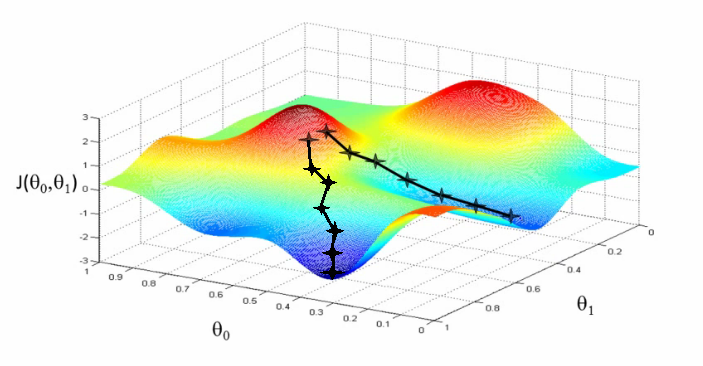

- GD的公式
    $ w_{i+1}= w_{i} - \eta \frac{\partial f(w)}{\partial w} $
- $ w_{i+1}$是第t+1步的位置,$\frac{\partial f(w)}{\partial w} $ 是微分, $\eta$是步长

### 1.1.2 GD的缺点
- 鞍点
    - 一个不是局部最小值的驻点（一阶导数为0的点）称为鞍点。
    - 数学含义是： 目标函数在此点上的梯度（一阶导数）值为 0， 但从改点出发的一个方向是函数的极大值点，而在另一个方向是函数的极小值点。
    - 鞍点的一个例子:
        - 公式: $z = x^{2} - y^{2} $, 函数图像
        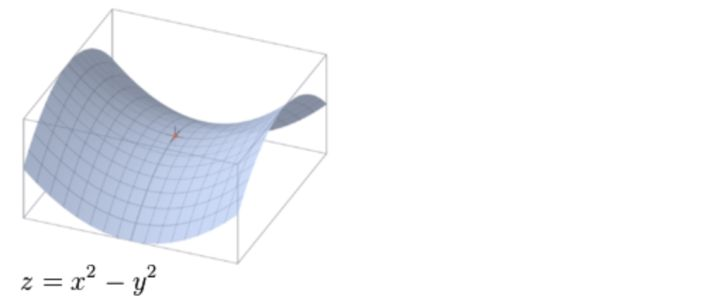
        - 公式: $z = x^{4} - y^{3} $ 的(0,0)也是鞍点

## 1.2 Stochastic Gradient Descent (SGD) 算法


- SGD的公式
    $ w_{i+1}= w_{i} - \eta J $
- $ w_{i+1}$是第t+1步的位置,$J$ 是随机微分, $\eta$是步长
- $J$的期望满足梯队函数
    - $E[J]= \frac{\partial f(w)}{\partial w}$
    
### 1.2.1 SGD的解释
虽然包含一定的随机性，但是从期望上来看，它是等于正确的导数的．用一张图来表示，其实SGD就像是喝醉了酒的GD，它依稀认得路，最后也能自己走回家，但是走得歪歪扭扭

# 2 定义函数实现SGD


## 2.1 加载数据 

导入MINST数据库手写体数据库

In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def transform_mnist(x):
    x = np.array(x, dtype='float32') / 255 # 将数据变到 0 ~ 1 之间
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

In [4]:
def download_mnist_data(batch_size):
    # transform 函数式编程, 对数据的变换 train指定测试训练
    # 载入数据集，申明定义的数据变换
    # 定义train=True or false
    train_set = MNIST(r'E:\ai\ai_lab\ai_case\ai_data\pytorch\MNIST\data', train=True, transform=transform_mnist, download=False) 
    test_set = MNIST(r'E:\ai\ai_lab\ai_case\ai_data\pytorch\MNIST\data', train=False, transform=transform_mnist, download=False)
    # 加载数据,打乱数据
    ## DataLoader: 批量取多少图片
    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    return train_data

## 2.2 定义网络,损失函数,梯度更新

In [5]:
# 使用 Sequential 定义 3 层神经网络
# 最后一层10个输出
net = nn.Sequential(
        nn.Linear(784, 200),
        nn.ReLU(),
        nn.Linear(200, 10),
)

In [6]:
# 定义 loss 函数
# 交叉熵函数
criterion = nn.CrossEntropyLoss()

In [7]:
# 定义根据梯队修改参数的方法
def sgd_update(parameters, lr):
    for param in parameters:
        param.data = param.data - lr * param.grad.data

## 2.3 定义网络的训练方法
- 直接把模型的参数梯度设成0:
    - model.zero_grad()
    - optimizer.zero_grad() 
    - 当optimizer=optim.Optimizer(model.parameters())时，两者等效
- 如果想要把某一Variable的梯度置为0
    - Variable.grad.data.zero_()

In [8]:
def train_net(net,train_data,lr):
    train_losses=[]
    train_loss = 0
    losses_idx = 0
    ### batch_size影响im,label的大小
    ### batch_size影响迭代次数.
    for im, label in train_data:
        # 定义变量:
        im = Variable(im)
        label = Variable(label)
        # 前向传播,传入输入,获得输出
        out = net(im)
        # 计算交叉熵损失函数: 根据前向传播的预测值和真是标签
        loss = criterion(out, label)
        # 将网络参数的梯队置为零
        net.zero_grad()
        ## 损失值的梯队
        # 默认 Variable 是不需要求梯度的， requires_grad=True 这个方式申明需要对其进行求梯度
        # 根据loss函数中,训练数据和标签数据, 自动对其他待计算参数的函数求偏导函数,并且计算参数偏导的梯队微分
        loss.backward()
        ## 对模型参数更新,
        ## 属性 net.parameters得到所有参数
        sgd_update(net.parameters(),lr) # 使用lr的学习率
        # 记录误差
        train_loss += loss.item()
        if losses_idx % 10 == 0:
            train_losses.append(loss.item())
        losses_idx += 1
    return (train_losses,train_loss,losses_idx)

In [15]:
def train(net,train_data,lr,batch_size):
    start = time.time() # 记时开始
    # 训练网络,记录损失值
    (train_losses,train_loss,losses_idx)=train_net(net,train_data,lr)
    end = time.time() # 计时结束
    print('epoch: 1, Train Loss: {:.6f}'.format(train_loss / len(train_data)))
    print('使用时间: {:.5f} s'.format(end - start))
    x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
    plt.semilogy(x_axis, train_losses, label='batch_size=%d'%batch_size)
    plt.legend(loc='best')

## 2.4 开始训练网络

In [10]:
train_data=download_mnist_data(batch_size=100)

epoch: 1, Train Loss: 0.352094
使用时间: 6.17349 s


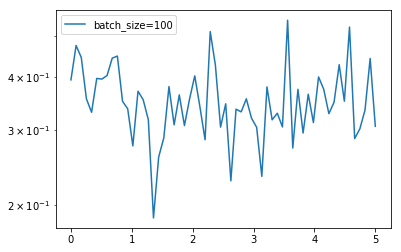

In [16]:
train(net,train_data,lr=1e-2,batch_size=100)